## 5.1

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

In [1]:
# read in the data
file_names = ["school1.dat", "school2.dat", "school3.dat"]

dfs = []
for i, fnm in enumerate(file_names):
    d = pd.read_table(fnm, header=None, names=['time'])
    d['school'] = fnm.split('.')[0]
    dfs.append(d)

df = pd.concat(dfs).reset_index(drop=True)

# priors parameters
mu0 = 5
kappa0 = 1
v0 = 2
sigma0_sq = 4

# school sufficient statistics
gp = df.groupby('school')
ns = gp.time.size()
y_bars = gp.time.mean()
vars = gp.time.var()

# posterior parameters
kns = kappa0 + ns
muns = (kappa0*mu0 + ns*y_bars) / kns
vns = v0 + ns
sigmans_sq = 1/vns * ((ns-1)*vars + v0*sigma0_sq + (kappa0*ns/kns)*(y_bars-mu0)**2)


np.random.seed(12123)

# drawing precision samples
precision_samples = stats.gamma(a=vns/2, scale=2/(vns*sigmans_sq)).rvs(size=(100000, 3))
vars_samples = 1 / precision_samples

# drawing mu samples given the precision samples
theta_samples = stats.norm(loc=muns, scale=np.sqrt(vars_samples/kns.values)).rvs()

In [11]:
pd.DataFrame(theta_samples).quantile((0.025, 0.975))

,0,1,2
0.025,7.768136,5.140580,6.165288
0.975,10.824765,8.733903,9.446978


In [13]:
pd.DataFrame(theta_samples).mean()

0    9.292008
1    6.943064
2    7.812310
dtype: float64

In [10]:
pd.DataFrame(np.sqrt(vars_samples)).quantile((0.025, 0.975))

,0,1,2
0.025,3.002397,3.345259,2.803659
0.975,5.175238,5.882706,5.125820


In [12]:
pd.DataFrame(np.sqrt(vars_samples)).mean()

0    3.906906
1    4.394512
2    3.749485
dtype: float64

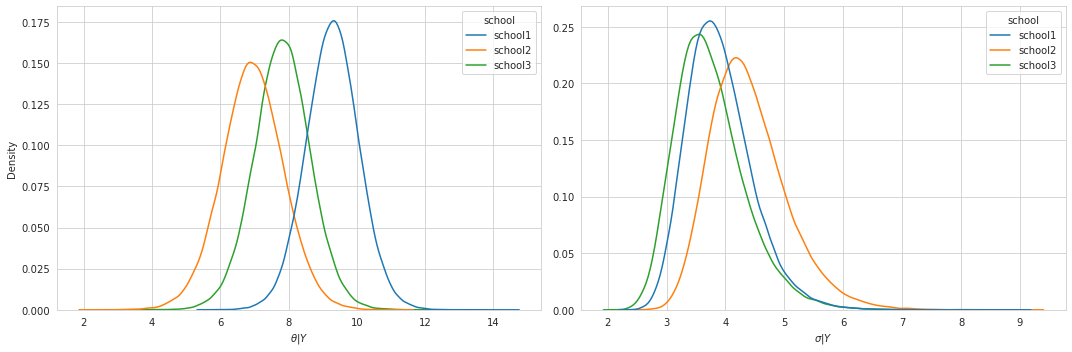

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

to_plot = (
    pd.DataFrame(theta_samples, columns=['school1','school2','school3'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['school', 'mu']
sns.kdeplot(data=to_plot, x='mu', hue='school', ax=ax[0])
ax[0].set_xlabel("$\\theta|Y$")

to_plot = (
    pd.DataFrame(vars_samples, columns=['school1','school2','school3'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['school', 'vars']
sns.kdeplot(data=to_plot, x=np.sqrt(to_plot.vars), hue='school', ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("$\\sigma|Y$")

fig.tight_layout()
fig.show()

In [26]:
from itertools import permutations

for a, b, c in permutations([0, 1, 2]):
    p = ((theta_samples[:, a] < theta_samples[:, b]) & (theta_samples[:, b] < theta_samples[:, c])).mean()
    print(a, b, c, p)

0 1 2 0.00572
0 2 1 0.00368
1 0 2 0.08407
1 2 0 0.67347
2 0 1 0.01517
2 1 0 0.21789


In [52]:
((theta_samples[:, 1] < theta_samples[:, 0]) & (theta_samples[:, 2] < theta_samples[:, 0])).mean()

0.89136

<AxesSubplot:xlabel='y_tilde', ylabel='Density'>

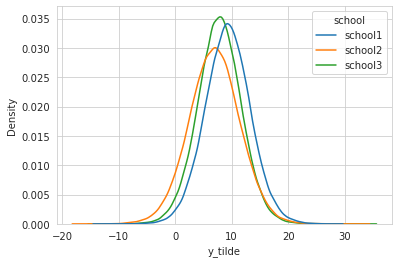

In [46]:
to_plot = (
    pd.DataFrame(stats.norm(loc=theta_samples, scale=np.sqrt(vars_samples)).rvs(), columns=['school1','school2','school3'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['school', 'y_tilde']
sns.kdeplot(data=to_plot, x='y_tilde', hue='school')

In [49]:
from itertools import permutations

post_y_samples = stats.norm(loc=theta_samples, scale=np.sqrt(vars_samples)).rvs()
for a, b, c in permutations([0, 1, 2]):
    p = ((post_y_samples[:, a] < post_y_samples[:, b]) & (post_y_samples[:, b] < post_y_samples[:, c])).mean()
    print(a, b, c, p)

0 1 2 0.10624
0 2 1 0.10467
1 0 2 0.18327
1 2 0 0.26838
2 0 1 0.13745
2 1 0 0.19999


In [51]:
((post_y_samples[:, 1] < post_y_samples[:, 0]) & (post_y_samples[:, 2] < post_y_samples[:, 0])).mean()

0.46837

## 5.2

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

In [87]:
np.random.seed(12123)
sample_size = 100000

ps = []
for epoch in range(8):
    # priors parameters
    kappa0, v0 = 2**epoch, 2**epoch
    mu0 = 75
    sigma0_sq = 100

    # group sufficient statistics
    ns = np.array([16, 16])
    y_bars = np.array([75.2, 77.5])
    vars = np.array([7.3, 8.1])**2

    # posterior parameters
    kns = kappa0 + ns
    muns = (kappa0*mu0 + ns*y_bars) / kns
    vns = v0 + ns
    sigmans_sq = 1/vns * ((ns-1)*vars + v0*sigma0_sq + (kappa0*ns/kns)*(y_bars-mu0)**2)

    # drawing precision samples
    precision_samples = stats.gamma(a=vns/2, scale=2/(vns*sigmans_sq)).rvs(size=(sample_size, 2))
    vars_samples = 1 / precision_samples

    # drawing mu samples given the precision samples
    theta_samples = stats.norm(loc=muns, scale=np.sqrt(vars_samples/kns)).rvs()

    ps.append((theta_samples[:,0] < theta_samples[:,1]).mean())

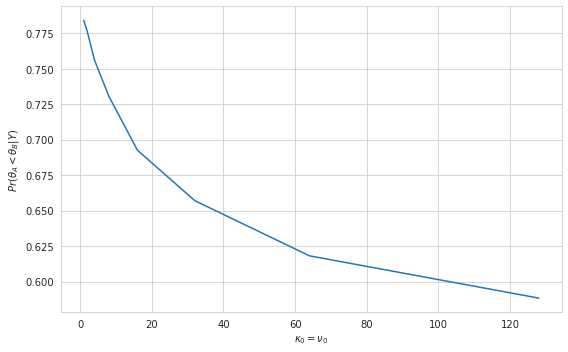

In [92]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(2**np.arange(8), ps)
ax.set_xlabel('$\\kappa_0=\\nu_0$')
ax.set_ylabel('$Pr(\\theta_A < \\theta_B|Y)$')
fig.tight_layout()
fig.show()

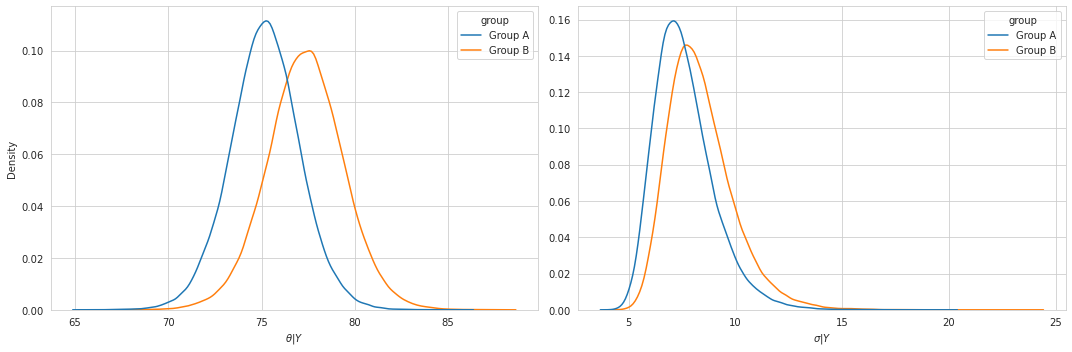

In [58]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))

to_plot = (
    pd.DataFrame(theta_samples, columns=['Group A','Group B'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['group', 'mu']
sns.kdeplot(data=to_plot, x='mu', hue='group', ax=ax[0])
ax[0].set_xlabel("$\\theta|Y$")

to_plot = (
    pd.DataFrame(vars_samples, columns=['Group A','Group B'])
      .unstack().reset_index()
      .drop('level_1', axis=1)
)
to_plot.columns = ['group', 'vars']
sns.kdeplot(data=to_plot, x=np.sqrt(to_plot.vars), hue='group', ax=ax[1])
ax[1].set_ylabel("")
ax[1].set_xlabel("$\\sigma|Y$")

fig.tight_layout()
fig.show()

## 6.1

In [187]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

sns.set_style('whitegrid')

In [188]:
def read_bach_file(fnm):
    data = []
    with open(fnm, "r") as t:
        for line in t.readlines():
            d = line.strip()
            if d == '': continue
            data.extend(list(map(int, d.split(' '))))
    return np.array(data)
    
bach = read_bach_file("menchild30bach.dat")
nobach = read_bach_file("menchild30nobach.dat")

In [205]:
burnin = 1000
epochs = 10000
target_stats = []

# observation data sufficient statistics
nA, mean_yA = bach.shape[0], bach.mean()
nB, mean_yB = nobach.shape[0], nobach.mean()

# for each gamma prior pair
for i in range(5):
    samples = []

    # prior parameter setup
    aθ, bθ = 2, 1
    aΓ, bΓ = 2**(i+3), 2**(i+3)

    # initial sample setup
    θ, Γ = 1.3, 1
    for epoch in range(burnin+epochs):
        # sample from the full conditionals
        θ_fullcond = stats.gamma(a=aθ+nA*mean_yA+nB*mean_yB, scale=1/(bθ+nA+nB*Γ))
        θ = θ_fullcond.rvs()

        Γ_fullcond = stats.gamma(a=aΓ+nB*mean_yB, scale=1/(bΓ+nB*θ))
        Γ = Γ_fullcond.rvs()

        samples.append((θ, Γ))

    # calculate the expectation from the samples
    df = pd.DataFrame(samples[burnin:], columns=['theta','gamma'])
    df['theta_B'] = df.theta * df.gamma
    s = (df.theta_B - df.theta).mean()
    target_stats.append(s)

<AxesSubplot:xlabel='gamma', ylabel='Density'>

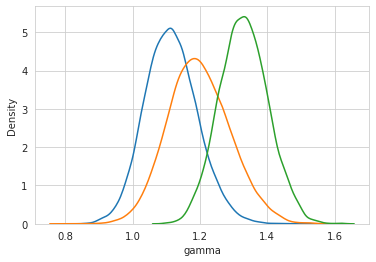

In [212]:
sns.kdeplot(df.gamma)
sns.kdeplot(df.theta)
sns.kdeplot(df.theta_B)

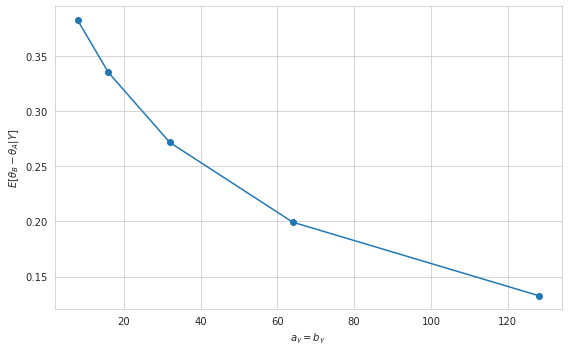

In [209]:
fig, ax = plt.subplots(figsize=(8, 5))

pd.Series(target_stats, index=2**(np.arange(5)+3)).plot(marker='o', ax=ax)

ax.set_xlabel('$a_\gamma = b_\gamma$')
ax.set_ylabel('$E[\\theta_B-\\theta_A|Y]$')
fig.tight_layout()
fig.show()